Make sure you have the below packages downladed (through pip install)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states

Census code was easy to get - just sign up for it with Lehigh University and your lehigh email.  

In [2]:
c = Census("bbecbd590e78f3a13ed534c7eda0c0024d6aea63")

In [3]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# FIPS code for CA is 06, just need to change VA to CA in state_flips
# These below are totals for the whole US population I think
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Do not have 2021 available yet, can only run through 2020
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
ca_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.CA.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2020)

In [4]:
# Create a dataframe from the census data
ca_df = pd.DataFrame(ca_census)

# Show the dataframe
print(ca_df.head(2))
print('Shape: ', ca_df.shape)

                                                NAME  C17002_001E  \
0  Census Tract 3131.02, Contra Costa County, Cal...       4263.0   
1  Census Tract 3131.04, Contra Costa County, Cal...       2740.0   

   C17002_002E  C17002_003E  B01003_001E state county   tract  
0        250.0         90.0       4367.0    06    013  313102  
1        292.0        411.0       2740.0    06    013  313104  
Shape:  (9129, 8)


In [5]:
# Access shapefile of Virginia census tracts
ca_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_06_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
ca_tract = ca_tract.to_crs(epsg = 32617)

# Print GeoDataFrame of shapefile
print(ca_tract.head(2))
print('Shape: ', ca_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(ca_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID   NAME            NAMELSAD  MTFCC  \
0      06      029  004402  06029004402  44.02  Census Tract 44.02  G5020   
1      06      047  000802  06047000802   8.02   Census Tract 8.02  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1865739       0  +35.5917343  -119.3337642   
1        S  2321653       0  +37.3433591  -120.5854604   

                                            geometry  
0  POLYGON ((-3044922.684 4694377.275, -3044853.5...  
1  POLYGON ((-3064475.527 4955010.244, -3064409.0...  
Shape:  (9129, 13)

The shapefile projection is: epsg:32617


In [6]:
# Combine state, county, and tract columns together to create a new string and assign to new column
ca_df["GEOID"] = ca_df["state"] + ca_df["county"] + ca_df["tract"]

In [7]:
# Print head of dataframe
ca_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 3131.02, Contra Costa County, Cal...",4263.0,250.0,90.0,4367.0,06,013,313102,06013313102
1,"Census Tract 3131.04, Contra Costa County, Cal...",2740.0,292.0,411.0,2740.0,06,013,313104,06013313104


In [8]:
# Remove columns
ca_df = ca_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
ca_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 3131.02, Contra Costa County, Cal...",4263.0,250.0,90.0,4367.0,06013313102
1,"Census Tract 3131.04, Contra Costa County, Cal...",2740.0,292.0,411.0,2740.0,06013313104


In [9]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(ca_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(ca_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [10]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
ca_merge = ca_tract.merge(ca_df, on = "GEOID")

# Show result
print(ca_merge.head(2))
print('Shape: ', ca_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID NAME_x            NAMELSAD  MTFCC  \
0      06      029  004402  06029004402  44.02  Census Tract 44.02  G5020   
1      06      047  000802  06047000802   8.02   Census Tract 8.02  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  1865739       0  +35.5917343  -119.3337642   
1        S  2321653       0  +37.3433591  -120.5854604   

                                            geometry  \
0  POLYGON ((-3044922.684 4694377.275, -3044853.5...   
1  POLYGON ((-3064475.527 4955010.244, -3064409.0...   

                                         NAME_y  C17002_001E  C17002_002E  \
0   Census Tract 44.02, Kern County, California       5204.0        387.0   
1  Census Tract 8.02, Merced County, California       4360.0        373.0   

   C17002_003E  B01003_001E  
0       1316.0       5209.0  
1        171.0       4360.0  
Shape:  (9129, 18)


In [11]:
# Create new dataframe from select columns
ca_poverty_tract = ca_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(ca_poverty_tract.head(2))
print('Shape: ', ca_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      06      029  004402  06029004402   
1      06      047  000802  06047000802   

                                            geometry  C17002_001E  \
0  POLYGON ((-3044922.684 4694377.275, -3044853.5...       5204.0   
1  POLYGON ((-3064475.527 4955010.244, -3064409.0...       4360.0   

   C17002_002E  C17002_003E  B01003_001E  
0        387.0       1316.0       5209.0  
1        373.0        171.0       4360.0  
Shape:  (9129, 9)


In [12]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
ca_poverty_county = ca_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(ca_poverty_county.head(2))
print('Shape: ', ca_poverty_county.shape)

                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((-3143474.678 5058327.671, -3143340.9...    1635239.0   
003       POLYGON ((-2938609.541 5086604.727, -2938597.7...       1159.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001           76379.0      75681.0    1661584.0  
003              55.0         84.0       1159.0  
Shape:  (58, 5)


In [13]:
# Get poverty rate and store values in new column
ca_poverty_county["Poverty_Rate"] = (ca_poverty_county["C17002_002E"] + ca_poverty_county["C17002_003E"]) / ca_poverty_county["B01003_001E"] * 100

# Show dataframe
ca_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((-3143474.678 5058327.671, -3143340.9...",1635239.0,76379.0,75681.0,1661584.0,9.151508
003,"POLYGON ((-2938609.541 5086604.727, -2938597.7...",1159.0,55.0,84.0,1159.0,11.993097


Text(0.5, 1.0, 'Poverty Rates (%) in California')

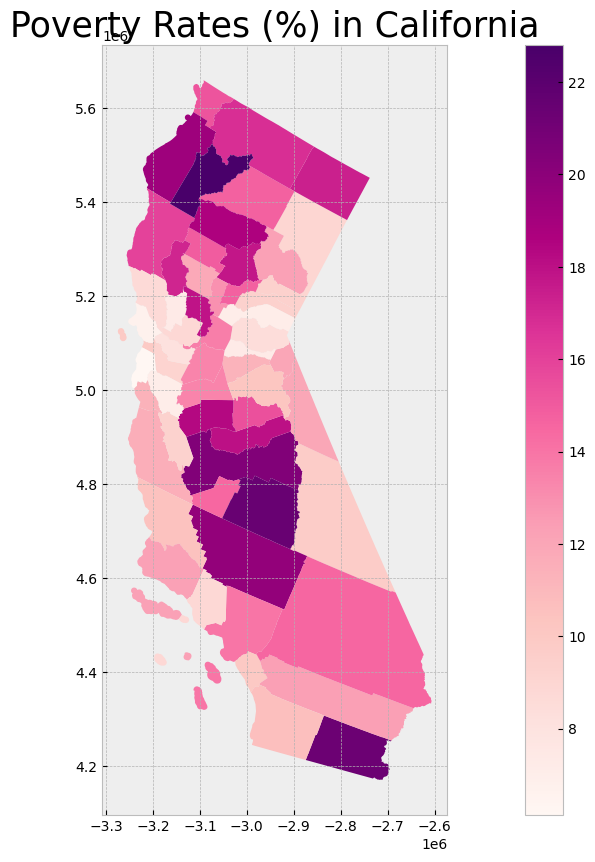

In [15]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
ca_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in California', fontdict = {'fontsize': '25', 'fontweight' : '3'})